# Viewing notifications and bundles

In this notebook we're trying to get a glimpse into bundles notifications data over our data sample.

In [14]:
%matplotlib notebook
import matplotlib.pyplot as plt
import statistics as stats

from lib.config import Config
from lib.models.bundle import Bundle
from lib.models.notification import Notification

In [3]:
bundles_filepath = "../data/bundles.csv"
notifications_filepath = "../data/notifications.csv"

In [15]:
# requires that `data/bundles.csv` exists
bundles = list()
user_bundles = dict()
with open(bundles_filepath, "r") as fp:
    for line in fp.readlines():
        bundle = Bundle.from_line(line)
        bundles.append(bundle)
        
        if bundle.receiver_id in user_bundles:
            user_bundles[bundle.receiver_id] += 1

        else:
            user_bundles[bundle.receiver_id] = 1
            
bundle_delays = [(b.timestamp_last_tour - b.timestamp_first_tour).total_seconds() / 60 for b in bundles]

In [7]:
notifications = list()
user_notifications = dict()
with open(notifications_filepath, "r") as fp:
    for line in fp.readlines():
        notification = Notification.from_line(line, Config.CSV_HEADERS)
        notifications.append(notification)
        
        if notification.user_id in user_notifications:
            user_notifications[notification.user_id] += 1

        else:
            user_notifications[notification.user_id] = 1

In [13]:
assert len(user_notifications) == len(user_bundles)
print(f"Number of notified users: {len(user_notifications)}")
print(f"Number of bundles: {len(bundles)}")
print(f"Number of notifications: {len(notifications)}\n")

print(f"Sample time span: {notifications[-1].timestamp - notifications[0].timestamp}")

Number of notified users: 14094
Number of bundles: 153992
Number of notifications: 337657

Sample time span: 61 days, 1:26:25


In [53]:
# converting notifs / bundle loads to daily values
time_window_secs = (notifications[-1].timestamp - notifications[0].timestamp).total_seconds()
time_window_days = time_window_secs / 3600 / 24

daily_user_bundles = {uid: val / time_window_days for uid, val in user_bundles.items()}
daily_user_notifications = {uid: val / time_window_days for uid, val in user_notifications.items()} 

In [54]:
daily_notifications_count = {val: 0 for val in daily_user_notifications.values()}
daily_bundles_count = {val: 0 for val in daily_user_bundles.values()}

for val in daily_user_notifications.values():
    daily_notifications_count[val] += 1
    
for val in daily_user_bundles.values():
    daily_bundles_count[val] += 1

<IPython.core.display.Javascript object>


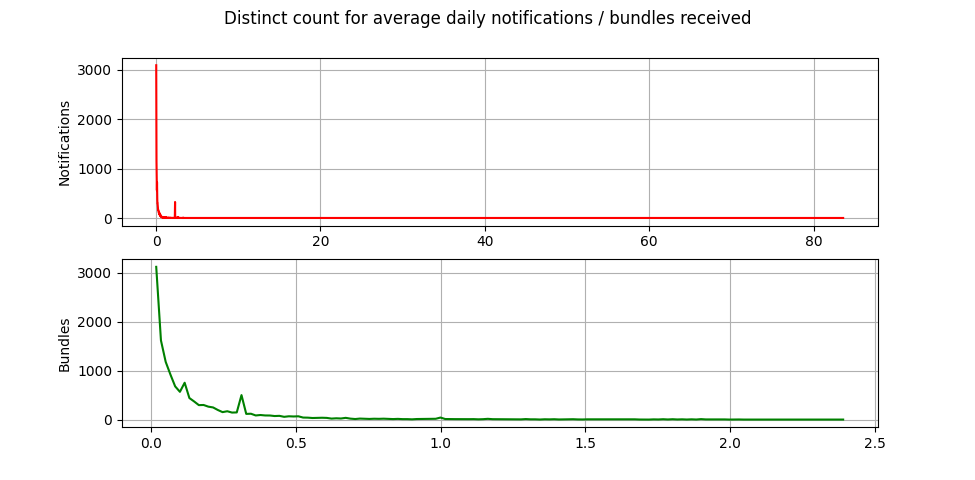

In [137]:
daily_notifications_count_sorted = sorted(list(daily_notifications_count.items()), key=lambda t: t[0])
daily_notifications_count_sorted_x = [t[0] for t in daily_notifications_count_sorted]
daily_notifications_count_sorted_y = [t[1] for t in daily_notifications_count_sorted]

daily_bundles_count_sorted = sorted(list(daily_bundles_count.items()), key=lambda t: t[0])
daily_bundles_count_sorted_x = [t[0] for t in daily_bundles_count_sorted]
daily_bundles_count_sorted_y = [t[1] for t in daily_bundles_count_sorted]

fig = plt.figure()
fig.suptitle('Distinct count for average daily notifications / bundles received')

plt.subplot(2, 1, 1)
plt.plot(daily_notifications_count_sorted_x, daily_notifications_count_sorted_y, 'r')
plt.ylabel('Notifications')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(daily_bundles_count_sorted_x, daily_bundles_count_sorted_y, 'g')
plt.ylabel('Bundles')
plt.grid(True)

plt.show()

## Metrics definition

The metrics we are interested in are the **average daily load of notifications per user** and the **average delay** between a notification's first tour timestamp and its time sent timestamp.

In [139]:
daily_avg_load_notifications = stats.mean(list(daily_user_notifications.values()))
daily_std_load_notifications = stats.stdev(list(daily_user_notifications.values()))

daily_avg_load_bundles = stats.mean(list(daily_user_bundles.values()))
daily_std_load_bundles = stats.stdev(list(daily_user_bundles.values()))

avg_delay_notifications = 0
std_delay_notifications = 0

bundle_delays = [(b.timestamp_last_tour - b.timestamp_first_tour).total_seconds() / 60 for b in bundles]

avg_delay_bundles = stats.mean(bundle_delays)
std_delay_bundles = stats.stdev(bundle_delays)

In [29]:
print(f"Average daily notifications load: {daily_avg_load_notifications:.3f} notifications/user/day")
print(f"Stdev daily notifications load: {daily_std_load_notifications:.3f} notifications/user/day\n")

print(f"Average daily bundles load: {daily_avg_load_bundles:.3f} bundles/user/day")
print(f"Stdev daily bundles load: {daily_std_load_bundles:.3f} bundles/user/day\n")

print(f"Average notification delay: {0:.3f} minutes")
print(f"Stdev notification delay: {0:.3f} minutes\n")

print(f"Average bundle delay: {avg_delay_bundles:.3f} minutes")
print(f"Stdev bundle delay: {std_delay_bundles:.3f} minutes")

Average daily notifications load: 0.392 notifications/user/day
Stdev daily notifications load: 2.267 notifications/user/day

Average daily bundles load: 0.179 bundles/user/day
Stdev daily bundles load: 0.277 bundles/user/day

Average notification delay: 0.000 minutes
Stdev notification delay: 0.000 minutes

Average bundle delay: 47.844 minutes
Stdev bundle delay: 185.566 minutes


## Percentile analysis

<IPython.core.display.Javascript object>


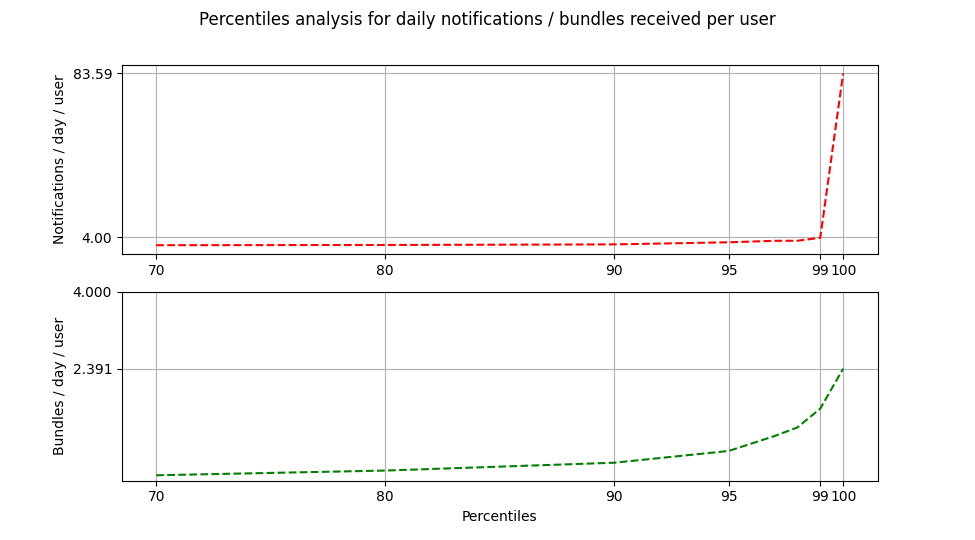

<IPython.core.display.Javascript object>


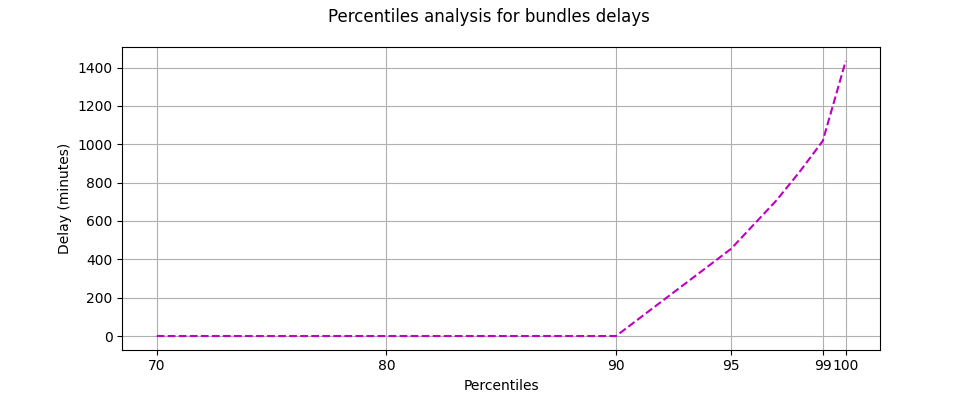

In [145]:
percentiles = [70, 80, 90, 95, 97, 98, 99, 100]

bundles_load_percentiles = [(p, np.percentile(list(daily_user_bundles.values()), p)) for p in percentiles]
bundles_load_percentiles_x = [bp[0] for bp in bundles_load_percentiles] 
bundles_load_percentiles_y = [bp[1] for bp in bundles_load_percentiles]

bundles_delay_percentiles = [(p, np.percentile(bundle_delays, p)) for p in percentiles]
bundles_delay_percentiles_x = [bp[0] for bp in bundles_delay_percentiles]
bundles_delay_percentiles_y = [bp[1] for bp in bundles_delay_percentiles]

notifications_percentiles = [(p, np.percentile(list(daily_user_notifications.values()), p)) for p in percentiles]
notifications_percentiles_x = [np[0] for np in notifications_percentiles]
notifications_percentiles_y = [np[1] for np in notifications_percentiles]

fig = plt.figure()
fig.suptitle('Percentiles analysis for daily notifications / bundles received per user')

plt.subplot(2, 1, 1)
plt.plot(notifications_percentiles_x, notifications_percentiles_y, 'r--')
plt.xticks([70, 80, 90, 95, 99, 100])
plt.yticks([4, max(notifications_percentiles_y)])
plt.ylabel('Notifications / day / user')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(bundles_load_percentiles_x, bundles_load_percentiles_y, 'g--')
plt.xticks([70, 80, 90, 95, 99, 100])
plt.yticks([4, max(bundles_load_percentiles_y)])
plt.ylabel('Bundles / day / user')
plt.xlabel('Percentiles')
plt.grid(True)

fig = plt.figure()
fig.suptitle('Percentiles analysis for bundles delays')

plt.plot(bundles_delay_percentiles_x, bundles_delay_percentiles_y, 'm--')
plt.xticks([70, 80, 90, 95, 99, 100])
plt.yticks()

plt.xlabel('Percentiles')
plt.ylabel('Delay (minutes)')
plt.grid(True)

plt.show()

### What this means

##### Load

We are setting a hard tick at 4 notifications / bundles per user daily. Given the percentile analysis on the daily load average per user on notifications / bundles we see that less than 1% of our total users are concerned with a load problem, breaking the daily 4 notifications hard limit.

Hence this is where we should concentrate our efforts.

##### Delay

###### Todo

## When does most activity happen during the day?

Let's try and find out.

<IPython.core.display.Javascript object>


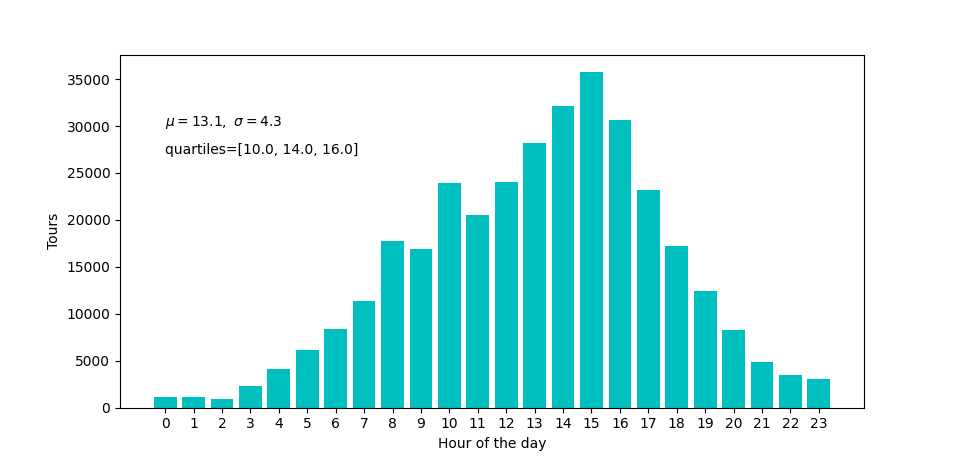

In [134]:
# scattering number of users (Y) receiving a given number of notifications (X)
tours_per_hour = {notification.timestamp.hour: 0 for notification in notifications}
for notification in notifications:
    tours_per_hour[notification.timestamp.hour] += 1
    
tours_per_hour_x = [t[0] for t in sorted(list(tours_per_hour.items()), key=lambda t: t[0])]
tours_per_hour_y = [t[1] for t in sorted(list(tours_per_hour.items()), key=lambda t: t[0])]

notifications_hours = [notification.timestamp.hour for notification in notifications]
avg_tours_per_hour = stats.mean(notifications_hours)
std_tours_per_hour = stats.stdev(notifications_hours)
quarts_tours_per_hour = stats.quantiles(notifications_hours, n=4

plt.bar(tours_per_hour_x, tours_per_hour_y, color='c')
plt.xticks(tours_per_hour_x)
plt.text(0, 30000, rf'$\mu={avg_tours_per_hour:.1f},\ \sigma={std_tours_per_hour:.1f}$')
plt.text(0, 27000, f'quartiles={quarts_tours_per_hour}')
plt.xlabel("Hour of the day")
plt.ylabel("Tours")
plt.show()